In [ ]:
train_dir = '//input/brain-tumor-mri-dataset/Training/'
test_dir = '/input/brain-tumor-mri-dataset/Testing/'

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2025-05-26 06:02:00.679578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748239321.151608      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748239321.289405      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_data = keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = None,
    image_size = (256,256),
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'categorical'
)

Found 5712 files belonging to 4 classes.


I0000 00:00:1748239344.891493      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748239344.892200      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
len(train_data)

179

In [5]:
test_data,val_data = keras.utils.image_dataset_from_directory(
    test_dir,
    
    validation_split = 0.5,
    subset = 'both',
    image_size = (256,256),
    seed = 1223,
    batch_size = 32,
    labels = 'inferred',
    label_mode = 'categorical'
)

Found 1311 files belonging to 4 classes.
Using 656 files for training.
Using 655 files for validation.


In [8]:
len(train_data), len(test_data), len(val_data)

(179, 21, 21)

In [9]:
classes = train_data.class_names

In [10]:
val_data.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [11]:
for img, label in train_data.take(1):
    for i in range(0,2):
        print(img[i].numpy().astype('int').shape)

(256, 256, 3)
(256, 256, 3)


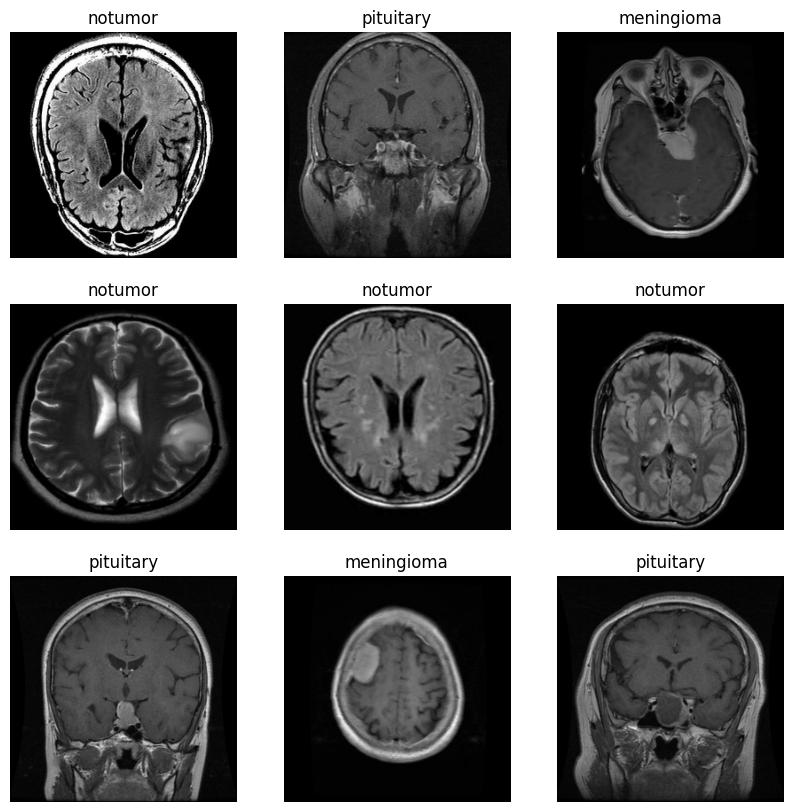

In [12]:
plt.figure(figsize = (10,10))
for img , label in train_data.take(1):
    for i in range(0,9):
        plt.subplot(3,3,i+1)
        
        plt.imshow(img[i].numpy().astype('uint'))
        plt.title(classes[np.argmax(label[i])])
        plt.axis('off')
        
        

In [13]:
len(train_data)

179

In [14]:
resize_and_rescale = keras.Sequential([
    keras.layers.Resizing(256,256),
    keras.layers.Rescaling(1./255)
])

In [15]:
resize_and_rescale.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:

data_aug = keras.Sequential([
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomFlip(),
    keras.layers.RandomTranslation(height_factor = 0.1, width_factor = 0.2),
    keras.layers.RandomContrast(0.1)
])

In [23]:
keras.Sequential([
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu')
])

<Sequential name=sequential_2, built=False>

In [24]:
sample_shape = tf.random.normal((1,256,256,3))
out = resize_and_rescale(sample_shape)
print(out.shape)

(1, 256, 256, 3)


In [19]:
from tensorflow.keras import backend as K

K.clear_session()

In [17]:
from keras.applications import Xception
base_model = Xception(include_top = False, weights = 'imagenet', pooling = 'max')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
img_shape = (256,256,3)

In [35]:
model = keras.Sequential([
    keras.layers.Input(shape = img_shape),
    resize_and_rescale, 
    base_model, 
    keras.layers.Flatten(),
    keras.layers.Dropout(rate= 0.3),
    keras.layers.Dense(128, activation= 'relu'),
    keras.layers.Dropout(rate= 0.25),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(rate = 0.15),
    keras.layers.Dense(4, activation= 'softmax')
])
# model.build(input_shape = (None,256,256,3))

In [36]:
model.summary()  

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,132,268 (80.61 MB)

 Trainable params: 21,077,740 (80.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [37]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy','precision', 'recall'])

In [39]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    restore_best_weights = True
)

In [40]:
hist = model.fit(train_data,
          validation_data = val_data , 
          epochs = 10,
          batch_size = 32,
          callbacks = [early_stop])

Epoch 1/10


E0000 00:00:1748241288.253322     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241288.516625     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241290.808622     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241291.032471     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241292.612707     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.9019 - loss: 0.3245 - precision: 0.9368 - recall: 0.8608

E0000 00:00:1748241451.884306      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241452.088827      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241453.529281      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241453.710839      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748241454.706755      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

179/179 ━━━━━━━━━━━━━━━━━━━━ 249s 983ms/step - accuracy: 0.9023 - loss: 0.3235 - precision: 0.9369 - recall: 0.8613 - val_accuracy: 0.6794 - val_loss: 4.6812 - val_precision: 0.6795 - val_recall: 0.6733
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 767ms/step - accuracy: 0.9650 - loss: 0.1361 - precision: 0.9768 - recall: 0.9456 - val_accuracy: 0.8885 - val_loss: 0.7659 - val_precision: 0.8904 - val_recall: 0.8809
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 756ms/step - accuracy: 0.9679 - loss: 0.1096 - precision: 0.9728 - recall: 0.9612 - val_accuracy: 0.8809 - val_loss: 0.4281 - val_precision: 0.8901 - val_recall: 0.8779
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 135s 755ms/step - accuracy: 0.9810 - loss: 0.0696 - precision: 0.9853 - recall: 0.9776 - val_accuracy: 0.9649 - val_loss: 0.0945 - val_precision: 0.9812 - val_recall: 0.9588
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 758ms/step - accuracy: 0.9814 - loss: 0.0733 - precision: 0.9842 - recall: 0.9781 - val_accuracy: 0.9176 - val

In [41]:
model.evaluate(test_data, verbose = 1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.9881 - loss: 0.0850 - precision: 0.9902 - recall: 0.9881


[0.09124819934368134,
 0.9832317233085632,
 0.9877488613128662,
 0.9832317233085632]

In [42]:
history = hist

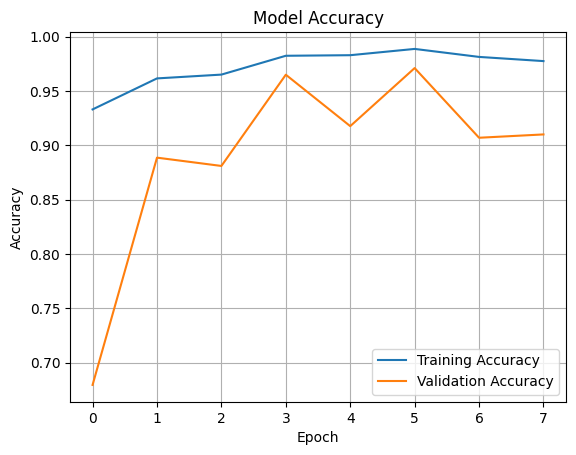

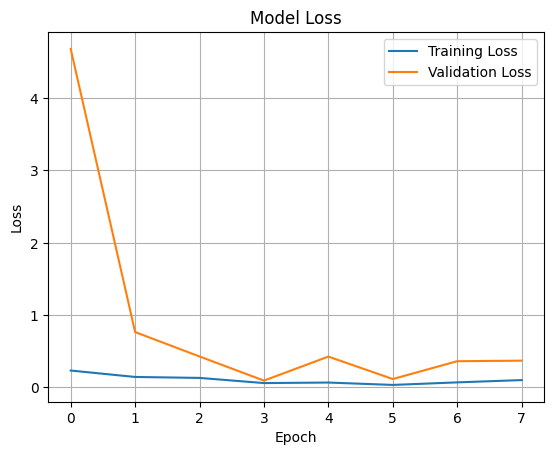

In [43]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
model.save('mrimodel.keras')

In [45]:
load_model = keras.models.load_model('mrimodel.keras')

In [46]:
load_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,287,750 (241.42 MB)

 Trainable params: 21,077,740 (80.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,155,482 (160.81 MB)

In [49]:
load_model.evaluate(test_data, verbose = 1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9855 - loss: 0.0517 - precision: 0.9881 - recall: 0.9855


[0.09124819189310074,
 0.9832317233085632,
 0.9877488613128662,
 0.9832317233085632]